# Figures for paper

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import pickle

sys.path.append("../src/")
from hamiltonian import *
from utils import *
from device import Device
from qiskit_circuits import *


import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore')
np.warnings.filterwarnings('ignore', category=DeprecationWarning)



from scipy.linalg import expm

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli
from qiskit.compiler import transpile
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['axes.facecolor'] = 'white'


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]})

In [75]:
## Global sizes for labels on plots 
xtick_size=16
ytick_size=16
legend_fontsize=18
textsize=18

# Basis states for the two systems
# This is the ordering of the labels in the paper; this is "normal" qubit ordering
# In Qiskit, when we grab the relevant things from the basis vectors, we need to grab the 
# *reverse*, so for OH we will be taking elements 1, 2, 4, 8, in that order, and for Qiskit
# 0, 1, 3, 2
states_gc = ['00', '10', '11', '01']
states_oh = ['1000', '0100', '0010', '0001']

diagonalized_values = np.array([
       [1,  -0.43658111],
        [2, -1.749160],
        [3, -2.045671], 
        [4, -2.1439810], 
        [5, -2.183592], 
        [6, -2.201568], 
        [7, -2.210416], 
        [8, -2.215038],
        [16, -2.221059]
]) 
# 

background_colors={"Gray code": "#bed3f7", 'One-hot':'#ffc1ab',"None":"lightgray"}

## Fig. 3

In [27]:
HEADERS = ['enc_type', 'n_states', 'sim_type', 'shots', 'optimizer', 'energy']
noise_free_data = pd.DataFrame(columns = HEADERS)



for directory in ["../paper-data/noise-free"]:
    for filename in os.listdir(f"{directory}"):
        if "energies.npy" not in filename:
            continue 
            
        enc_type = ""
        if 'gray_code' in filename:
            enc_type = "Gray code"
        else:
            enc_type = "One-hot"
            if 'original' in directory:
                enc_type += "-original"
                
        optimizer = 'SPSA' if 'SPSA' in filename else 'Nelder-Mead'
        sim_type = 'QASM' if 'qasm' in filename else 'Statevector'
        n_shots = 0
        n_states = int(filename.split("-")[3].split("_")[0])

        base_dict = {'enc_type' : enc_type,
                    'n_states' : n_states,
                    'sim_type' : sim_type,
                    'shots' : 10000,
                    'optimizer' : optimizer}                  

        data = np.load(f"{directory}/{filename}")

        for energy in data:
            next_dict = base_dict
            next_dict['energy'] = energy
            noise_free_data = noise_free_data.append(next_dict, ignore_index=True)

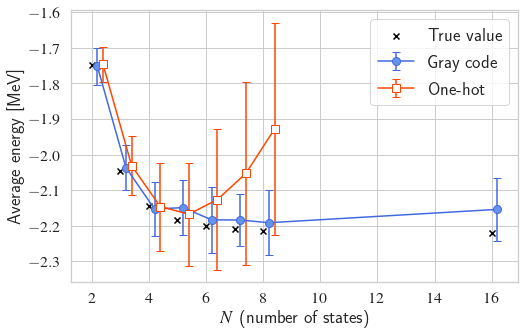

In [28]:
## Fig3a
colours ={"Gray code" : "royalblue", "One-hot" : "orangered"}
markers = {'Gray code': 'o', 'One-hot': 's'}
fill_colour = {'Gray code': 'cornflowerblue', 'One-hot': 'white'}

plt.figure(figsize=(8, 5))

## Exact value
plt.scatter(
    x=diagonalized_values[:,0][1:], ## don't plot for n=1
    y=diagonalized_values[:, 1][1:],
    marker='x', color='black', 
    label='True value'
)

for encoding_key, subgroup in noise_free_data.loc[noise_free_data["sim_type"]=="QASM"].groupby(['enc_type']):
    split_by_state = subgroup.groupby(['n_states'])
    n_states = np.array(list(split_by_state.groups.keys()))
    means = split_by_state['energy'].mean()
    stds = split_by_state['energy'].std()

    ## apply offset
    if encoding_key == "Gray code":
        n_states=n_states+0.2
    elif encoding_key == "One-hot":
        n_states=n_states+0.4

    plt.errorbar(n_states, means, yerr=stds, capsize=4, 
                 marker=markers[encoding_key], 
                 markersize=8, 
                 label=encoding_key, 
                 color=colours[encoding_key], 
                 mfc=fill_colour[encoding_key]
                )

# properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
# plt.text(11.5,-2.0,"QASM simulator\n Shots: 10000",fontsize=textsize,bbox=properties)

plt.xlabel("$N$ (number of states)", fontsize=textsize)
plt.ylabel("Average energy [MeV]", fontsize=textsize)
plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=ytick_size)

plt.legend(fontsize=textsize)

plt.savefig(f'../paper-figures/fig3-nonoise-qasm-avgenergy.pdf')

plt.show()

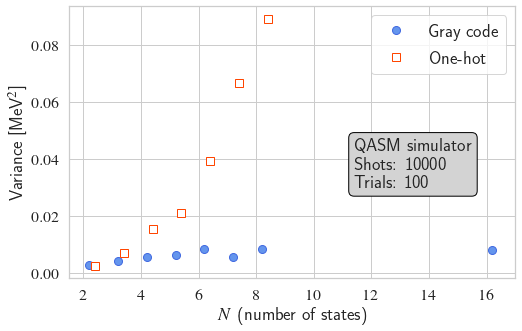

In [62]:
## Fig3b
plt.figure(figsize=(8, 5))
for encoding_key, subgroup in noise_free_data.loc[
        noise_free_data["sim_type"]=="QASM"].groupby(['enc_type']):
    split_by_state = subgroup.groupby(['n_states'])
    n_states = np.array(list(split_by_state.groups.keys()))
    
    ## apply offset
    if encoding_key == "Gray code":
        n_states=n_states+0.2
    elif encoding_key == "One-hot":
        n_states=n_states+0.4

    plt.plot(n_states,
             split_by_state['energy'].var(), 
             linestyle='none', 
             marker=markers[encoding_key], 
             ms=8, 
             label=encoding_key, 
             color=colours[encoding_key], 
             mfc=fill_colour[encoding_key]
            )

properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
plt.text(11.4,0.03,"QASM simulator\n Shots: 10000\n  Trials: 100",fontsize=textsize,bbox=properties)

plt.legend(fontsize=textsize)

plt.xlabel("$N$ (number of states)", fontsize=textsize)
plt.ylabel("Variance [MeV$^2$]", fontsize=textsize)

plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=ytick_size)
plt.xlim(1.5, 17)




plt.savefig("../paper-figures/fig3-nonoise-qasm-variance.pdf")

plt.show()

## Fig.4

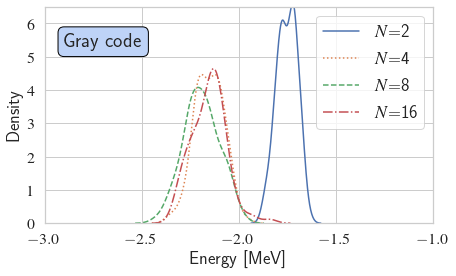

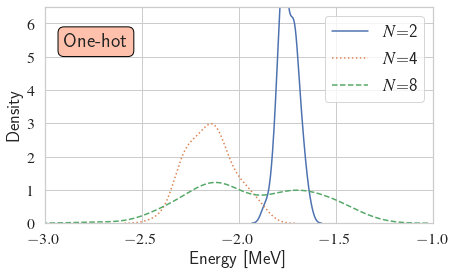

In [83]:
linestyles = ['solid', 'dotted', 'dashed', 'dashdot']

for key, grp in noise_free_data.groupby(['sim_type', 'enc_type']):
    if key[0] == 'Statevector':
        continue 
    
    plt.figure(figsize=(6.5, 4))
    
    count = 0
    for nstates, state_group in grp.groupby(['n_states']):
        if nstates in [2, 4, 8, 16]:
            sns.kdeplot(state_group['energy'], bw_method='scott', label=f"$N$={nstates}", linestyle=linestyles[count])
            count += 1
#     Already indicated in Fig. 3 referenced in caption of Fig. 4       
#     if key[1]=="One-hot":
#         properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
#         plt.text(-2.93,6.2,"QASM simulator\n Shots: 10000",fontsize=textsize,bbox=properties)

    properties=dict(boxstyle='round',edgecolor="black",facecolor=background_colors[key[1]], alpha=1.0)
    plt.text(-2.9,5.3,f"{key[1]}",fontsize=20,bbox=properties)


    plt.legend(fontsize=textsize)        
    
    plt.xlabel("Energy [MeV]", fontsize=textsize)
    plt.ylabel("Density", fontsize=textsize)
    plt.xticks(np.arange(-3, 0, 0.5),fontsize=xtick_size)
    plt.yticks(fontsize=ytick_size)
    plt.xlim(-3, -1)
    plt.ylim(0, 6.5)
    
#     title_string = f"{key[1]} encoding "
#     plt.title(title_string, fontsize=20)
    
    plt.tight_layout()

    if key[1]=="Gray code":
        plt.savefig(f"../paper-figures/fig4-gray-code.pdf")
    elif key[1]=="One-hot":
        plt.savefig(f"../paper-figures/fig4-one-hot.pdf")


## Fig. 6

In [77]:
def get_layout(filename):
    sub_str=filename.split("layout-")[-1].strip('-energies.npy').strip("-mit_meas").replace("-",",")
    layout="{"+sub_str+"}"
    return layout

HEADERS = [
    "device","layout","enc_type","n_states","sim_type",
    "shots","optimizer","energy","meas_mit",
    ]

noisy_data = pd.DataFrame(columns=HEADERS)

### Get data
data_dir="../paper-data/noise"
glob_str=f"{data_dir}/2020-07-*states-qasm_simulator-10000_shots-SPSA-*energies.npy"
filenames=set(glob.glob(glob_str))-set(glob.glob(f"{data_dir}/*CNOT*.npy"))

for filename in filenames:

    if "4_states" in filename:
        n_states = 4
    elif "8_states" in filename:
        n_states = 8

    if "vigo" in filename:
        device_name = "vigo"
    elif "yorktown" in filename:
        device_name = "yorktown"
    elif "no_device" in filename:
        device_name = "no_device"
    else:
        continue

    layout = get_layout(filename) if "layout" in filename else "None"
    circle_layout="{4,2,3}"
    circ="None" if len(layout)!=7 else f"{layout==circle_layout}"
    enc_type = "Gray code" if "gray_code" in filename else "One-hot"
    meas_mit = "True" if "mit_meas" in filename else "False"
    if device_name == "no_device":
        meas_mit = "None"
    

    n_shots = 10000

    base_dict = {
        "device": device_name,
        "layout": layout,
        "enc_type": enc_type,
        "n_states": n_states,
        "sim_type": sim_type,
        "shots": n_shots,
        "optimizer": optimizer,
        "meas_mit": meas_mit,
        "circ": circ,
    }

    data = np.load(f"{filename}")    

    for energy in data:
        next_dict = base_dict
        next_dict["energy"] = energy
        noisy_data = noisy_data.append(next_dict, ignore_index=True)

In [8]:
# print(
#     noisy_data.groupby(
#         ["device","layout","enc_type","sim_type","n_states","shots","optimizer","meas_mit","circ",]
#     ).describe())

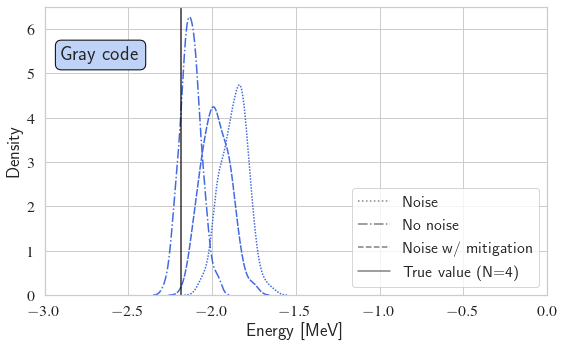

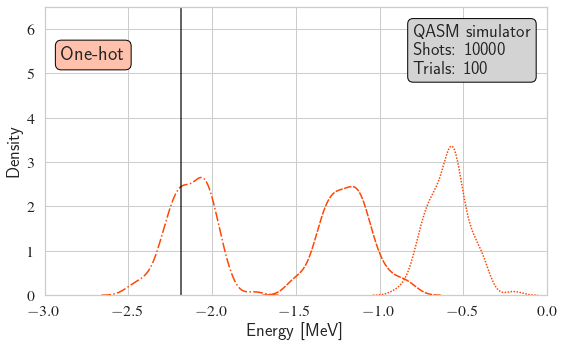

In [131]:
colours = {"Gray code": "royalblue", "One-hot": "orangered", "None": "tab:gray"}
linestyles = {"True": (0, (5, 1)), "False": (0, (1, 1)), "None": "-."}

selection_criteria = (noisy_data["n_states"] == 4) 
selection_criteria &= ((noisy_data["device"] == "vigo") | (noisy_data["device"] == "no_device"))
for key, grp in noisy_data[selection_criteria].groupby("enc_type"):
    
    fig, ax = plt.subplots(figsize=(8, 5))


    for mit_key, mit_grp in grp.groupby(["meas_mit", "layout", "device"]):
        if mit_key[0] == "False":
            label = "Noise"
        elif mit_key[0] == "True":
            label = "Noise w/ mitigation"
        elif mit_key[0] == "None":
            label = "No noise"
        else:
            raise ValueError

        sns.kdeplot(
            mit_grp["energy"],
            bw_method="scott",
            label=label,
            color=colours[key],
            linestyle=linestyles[mit_key[0]],
            ax=ax,
        )

    ax.axvline(
        x=diagonalized_values[4][1],
        color="black",
        label="True value (N = 4)",
        alpha=0.8,
    )

    if key == "Gray code":
        m1 = mlines.Line2D([], [], color="grey", ls=":")
        m2 = mlines.Line2D([], [], color="grey", ls="--")
        m3 = mlines.Line2D([], [], color="grey", ls="-.")
        m4 = mlines.Line2D([], [], color="grey", ls="-")
        ax.legend(
            (m1, m3, m2, m4),
            ("Noise", "No noise", "Noise w/ mitigation", "True value (N=4)"),
            fontsize=16,
            loc="lower right",
        )
    if key == "One-hot":
        properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
        plt.text(-0.8,5,"QASM simulator\n Shots: 10000\n Trials: 100",fontsize=textsize,bbox=properties)

    properties=dict(boxstyle='round',edgecolor="black",facecolor=background_colors[key], alpha=1.0)
    plt.text(-2.9,5.3,f"{key}",fontsize=20,bbox=properties)
        
    ax.set_ylabel("Density", fontsize=textsize)
    ax.set_xlabel("Energy [MeV]", fontsize=textsize)
    ax.set_xlim(-3, 0)
    plt.ylim(0, 6.5)
    # ax.set_xticks(fontsize=16)
    # ax.set_yticks(fontsize=16)
    ax.tick_params(labelsize=xtick_size)

#     title_string = f"{key} encoding"
#     ax.set_title(title_string, fontsize=20)

    fig.tight_layout()
    tag="gray-code" if key == "Gray code" else "one-hot"
    plt.savefig(f"../paper-figures/fig6-{tag}.pdf")
    plt.show()

## Fig. 7

In [10]:
data_dir="../paper-data/noise"

device = "ibmq_vigo"
encodings = ["one_hot", "gray_code"]
layout = {"gray_code": "2-1", "one_hot": "2-1-3-4"}
nCNOTs = np.array([0, 1, 2, 3])
colours = {"gray_code": "royalblue", "one_hot": "orangered"}
markers = {"gray_code": "o", "one_hot": "s"}
fillcolour = {"gray_code": "cornflowerblue", "one_hot": "coral"}

extrapolation_data = pd.DataFrame(
    columns=[
        "encoding",
        "CNOTs",
        "mean",
        "std",
    ]
)
for encoding in encodings:
    for n in nCNOTs:
        filename = f"{data_dir}/2020-07-29_{encoding}-4_states-qasm_simulator-10000_shots-SPSA-{device}_layout-{layout[encoding]}-mit_meas-CNOTs{n}-energies.npy"
        data = np.load(filename)
        mu = np.mean(data)
        err = np.std(data)
        datadict = {"encoding": encoding, "CNOTs": n, "mean": mu, "std": err}
        extrapolation_data = extrapolation_data.append(datadict, ignore_index=True)


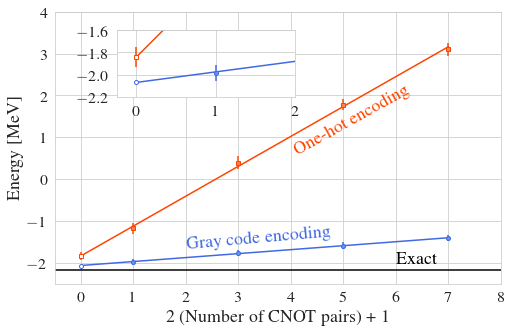

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
ins = inset_axes(
    ax,
    width="50%",
    height="35%",
    bbox_to_anchor=(-0.25, 0.25, 0.8, 0.7),
    bbox_transform=ax.transAxes,
)

ax.axhline(y=diagonalized_values[4][1], ls="-", c="k")

ms = 4
oppfill = {}
oppfill["gray_code"] = "white"
oppfill["one_hot"] = "orangered"

for enckey, encgrp in extrapolation_data.groupby("encoding"):
    # do fit
    x = 2 * nCNOTs + 1
    y = encgrp["mean"]
    y_e = encgrp["std"]
    coef, cov = np.polyfit(x, y, 1, cov=True, w=1 / y_e)
    ax.errorbar(x,y,y_e,
        color=colours[enckey],
        marker=markers[enckey],
        ms=ms,
        ls="",
        mfc=fillcolour[enckey],
    )

    ax.errorbar([0,],[coef[-1],],
        yerr=[np.sqrt(cov[-1, -1]),],
        marker=markers[enckey],
        ms=ms,
        color=colours[enckey],
        mfc="white",
    )
    poly1d_fn = np.poly1d(coef)
    ax.plot([0, max(x)], poly1d_fn([0, max(x)]), color=colours[enckey], ms=ms, ls="-")

    # repeat for inset
    ins.errorbar(x,y,y_e,
        color=colours[enckey],
        marker=markers[enckey],
        ms=ms,
        ls="",
        mfc=fillcolour[enckey],
    )

    ins.errorbar(
        [0,],
        [coef[-1],],
        yerr=[np.sqrt(cov[-1, -1]),],
        marker=markers[enckey],
        ms=ms,
        color=colours[enckey],
        mfc="white",
    )
    ins.plot([0, max(x)], poly1d_fn([0, max(x)]), color=colours[enckey], ms=ms, ls="-")


ax.annotate(
    r"One-hot encoding",
    color=colours["one_hot"],
    xy=(4, 0.6),
    rotation="29",
    fontsize=textsize,
)
ax.annotate("Exact", xy=(6, -2), c="k", fontsize=textsize)
ax.annotate(
    r"Gray code encoding",
    color=colours["gray_code"],
    xy=(2, -1.65),
    rotation="5",
    fontsize=textsize,
)
ax.set_ylabel("Energy [MeV]", fontsize=textsize)
ax.set_xlabel("2 (Number of CNOT pairs) + 1", fontsize=textsize)
ax.set_xticks(range(-1, 10))
ins.set_xticks(range(-1, 10))
ax.set_yticks(np.arange(-3, 5, 1))
ins.set_yticks(np.arange(-3, 2, 0.2))
ax.set_yticks(np.arange(-3, 2, 0.25), minor=True)
ins.set_yticks(np.arange(-3, 2, 0.05), minor=True)
ax.tick_params(axis="x", labelsize=xtick_size)
ax.tick_params(axis="y", labelsize=ytick_size)
ins.tick_params(axis="x", labelsize=xtick_size)
ins.tick_params(axis="y", labelsize=ytick_size)
ax.set_xlim(-0.5, 8)
ax.set_ylim(-2.5, 4)
ins.set_xlim(-0.25, 2)
ins.set_ylim(-2.2, -1.6)
plt.savefig(f"../paper-figures/fig7-extrapolation_zero_noise.pdf")

## Fig. 8

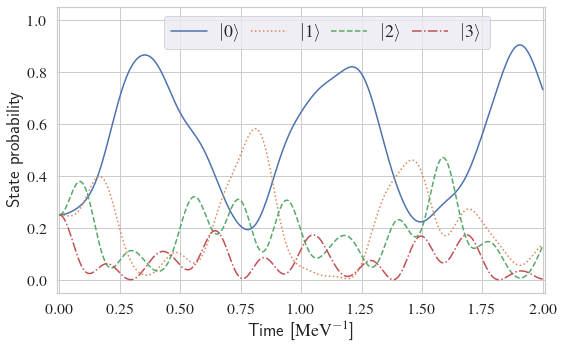

In [87]:
# Perform unitary evolution 
def unitary_evolution(ham, t):
    return expm(-1j * ham * t)

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = {0: '-', 1: ':', 2: '--', 3: '-.'}

# Some simulation parameters; for better 'resolution', increase the number of timesteps 
timesteps = 1000
start_time = 0
end_time = 2
time_range = np.linspace(start_time, end_time, timesteps)
trajectories_gc = np.zeros((timesteps, 4))

H_gc = DenseEncodingHamiltonian(N_states=4)
gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_gc.pauli_coeffs.items()])
uniform_gc = 0.5 * np.array([[1], [1], [1], [1]])

for time_idx, time in enumerate(list(time_range)):
    wavefunction = unitary_evolution(gc_ham_rep, t=time) @ uniform_gc
    true_probabilities = (wavefunction * np.conj(wavefunction)).flatten()
    # Need to pull probabilities in the correct ordering that we have basis states in - 00, 10, 11, 01
    trajectories_gc[time_idx, 0] = true_probabilities[0].real
    trajectories_gc[time_idx, 1] = true_probabilities[1].real
    trajectories_gc[time_idx, 2] = true_probabilities[3].real
    trajectories_gc[time_idx, 3] = true_probabilities[2].real

sns.set(rc={'figure.figsize':(16,8)})
plt.figure(figsize=(8, 5))
with sns.axes_style("whitegrid"):
    for state_idx, state in enumerate(states_gc):
        plt.plot(time_range, trajectories_gc[:, state_idx], 
                 label=f"$\left \\vert {state_idx} \\right\\rangle$", 
                 linestyle=linestyles[state_idx]
                )
        
plt.xlabel("Time [$\mathrm{MeV}^{-1}$]", fontsize=textsize)
plt.ylabel("State probability", fontsize=textsize)
plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=ytick_size)
# plt.title("Evolution of basis states under $N=4$ Hamiltonian", fontsize=textsize)
plt.legend(fontsize=textsize, bbox_to_anchor=(.2,1), loc='upper left',ncol=len(states_gc),columnspacing=.5);
plt.ylim(-0.05,1.05)
plt.xlim(-0.01,2.01)
plt.tight_layout()

plt.savefig("../paper-figures/fig8-ham_sim_trajectory.pdf")


## Fig. 9

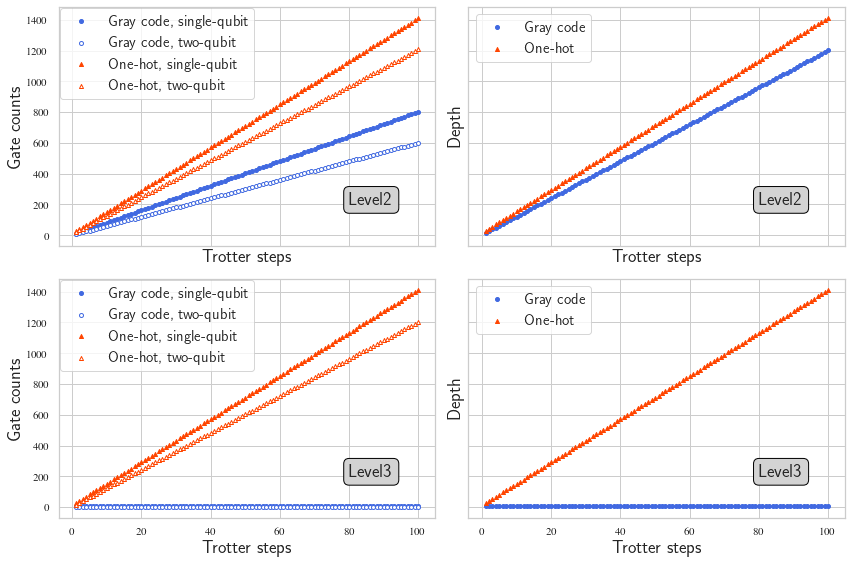

In [99]:

sns.set_style('whitegrid')
plt.rcParams['axes.facecolor'] = 'white'

data_directory="../paper-data/hamiltonian-simulation"
filename_gc = f'{data_directory}/paperfig9-ham-sim-gate-counts-gray-code.npy'
filename_oh = f'{data_directory}/paperfig9-ham-sim-gate-counts-one-hot.npy'

gate_counts_gc = np.load(filename_gc,allow_pickle=True)
gate_counts_oh = np.load(filename_oh,allow_pickle=True)

colours = {"Gray code": "royalblue", "One-hot": "orangered", None: "tab:gray"}
fill_colours = {"Gray code": "cornflowerblue", "One-hot": "coral", None: "white"}
markers = {"Gray code": "o", "One-hot": "^"}
marker_size=16
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))


# Arbitrary simulation time
T = 1

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

## for text box 
properties=dict(boxstyle='round',edgecolor="black",facecolor=background_colors["None"], alpha=1.0)

# Plot in subplots
for opt_level in range(2, 4):    
    encoding="Gray code"
    ax[opt_level-2, 0].scatter(
                            x=range(min_trotter_steps, max_trotter_steps+1), 
                            y=gate_counts_gc[opt_level,:,0],
                            label=f'{encoding}, single-qubit', 
                            marker=markers[encoding],
                            color=colours[encoding],
                            s=marker_size
                        )
    
    ax[opt_level-2, 0].scatter(
                            x=range(min_trotter_steps, max_trotter_steps+1), 
                            y=gate_counts_gc[opt_level,:,1],
                            label=f'{encoding}, two-qubit', 
                            marker=markers[encoding],
                            color=colours[encoding],
                            facecolor=fill_colours[None],
                            s=marker_size
                        )
    
    encoding="One-hot"
    ax[opt_level-2, 0].scatter(
                            x=range(min_trotter_steps, max_trotter_steps+1), 
                            y=gate_counts_oh[opt_level,:,0],
                            label=f'{encoding}, single-qubit', 
                            marker=markers[encoding],
                            color=colours[encoding],
                            s=marker_size
                        )
    
    ax[opt_level-2, 0].scatter(x=range(min_trotter_steps, max_trotter_steps+1), 
                            y=gate_counts_oh[opt_level,:,1],
                            label=f'{encoding}, two-qubit',
                            marker=markers[encoding],
                            color=colours[encoding],
                            facecolor=fill_colours[None],
                            s=marker_size
                        )
    
    
    ax[opt_level-2, 0].text(80,200,f"Level{opt_level}",fontsize=textsize,bbox=properties)
    ax[opt_level-2, 1].text(80,200,f"Level{opt_level}",fontsize=textsize,bbox=properties)
    
    encoding="Gray code"
    ax[opt_level-2, 1].scatter(x=range(min_trotter_steps, max_trotter_steps+1), 
                             y=gate_counts_gc[opt_level,:,2],
                             label=f'{encoding}', 
                            marker=markers[encoding],
                            color=colours[encoding],
                            s=marker_size 
                          )
    encoding="One-hot"
    ax[opt_level-2, 1].scatter(
                            x=range(min_trotter_steps, max_trotter_steps+1), 
                            y=gate_counts_oh[opt_level,:,2],
                            label=f'{encoding}',
                            marker=markers[encoding],
                            color=colours[encoding],
                            s=marker_size
                        )
    
    ax[opt_level-2, 0].set_xlabel("Trotter steps", fontsize=textsize)
    ax[opt_level-2, 0].set_ylabel("Gate counts", fontsize=textsize)
    ax[opt_level-2, 1].set_xlabel("Trotter steps", fontsize=textsize)
    ax[opt_level-2, 1].set_ylabel("Depth", fontsize=textsize)
#     ax[opt_level-2, 0].set_title(f"Level {opt_level} gate counts", fontsize=textsize)
#     ax[opt_level-2, 1].set_title(f"Level {opt_level} depth", fontsize=textsize)
    ax[opt_level-2, 0].legend(fontsize=15,loc="upper left",bbox_to_anchor=(-0.015,1.025))
    ax[opt_level-2, 1].legend(fontsize=15)

#     ax.tick_params(labelsize=xtick_size)
# plt.suptitle("Resources for $N=4$ Hamiltonian evolution circuits", fontsize=20)    
plt.tight_layout()

plt.savefig("../paper-figures/fig9-hamsim-resource-estimates.pdf")

## Fig. 10

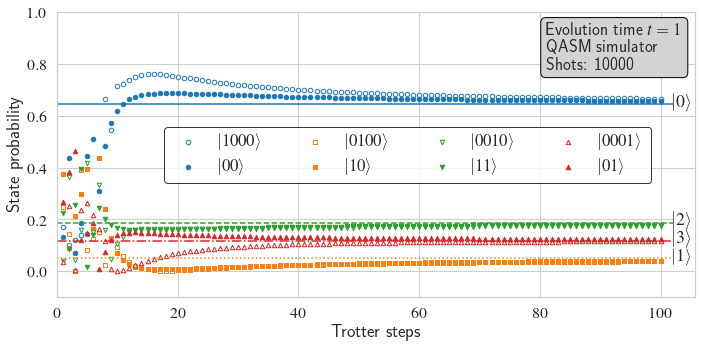

In [154]:
data_directory="../paper-data/hamiltonian-simulation"
filename_gc = f'{data_directory}/paperfig10-ham-sim-qasm-probs-gray-code.npy'
filename_oh = f'{data_directory}/paperfig10-ham-sim-qasm-probs-one-hot.npy'
results_dict_gc = np.load(filename_gc,allow_pickle=True).flat[0]
results_dict_oh = np.load(filename_oh,allow_pickle=True).flat[0]

# trajectories_oh = np.zeros((timesteps, 4))
T = 1
oh = SparseEncodingHamiltonian(N_states=4)
oh_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in oh.pauli_coeffs.items()])
uniform_oh = 0.5 * np.array([[0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0]]).reshape((16, 1))
exact_wavefunction_oh = unitary_evolution(oh_ham_rep, t=T) @ uniform_oh
true_probabilities = (exact_wavefunction_oh * np.conj(exact_wavefunction_oh)).flatten()
true_results_oh = {'1000' : true_probabilities[1],
                   '0100' : true_probabilities[2],
                   '0010' : true_probabilities[4],
                   '0001' : true_probabilities[8]
                  }

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ["o","s","v","^"]
linestyles = {0: '-', 1: ':', 2: '--', 3: '-.'}

sns.set(rc={'figure.figsize':(10,5)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')

states=list(zip(states_gc, states_oh))
for i in range(len(states)):
# for state_gc, state_oh in list(zip(states_gc, states_oh)):
    state_gc,state_oh=states[i]

    plt.scatter(
        x=range(min_trotter_steps, max_trotter_steps+1), 
        y=results_dict_oh[state_oh], 
        label=f"$\left \\vert {state_oh} \\right\\rangle$", 
        color=colours[i], 
        marker=markers[i],
        facecolor="white",
         s=20
    )
    plt.scatter(
        x=range(min_trotter_steps, max_trotter_steps+1), 
        y=results_dict_gc[state_gc], 
        label=f"$\left \\vert {state_gc} \\right\\rangle$", 
        color=colours[i],
        marker=markers[i],
        facecolor=colours[i],
         s=20
    )

    properties=dict(color="white", alpha=1.0,pad=0.0)
    plt.text(102,true_results_oh[state_oh].real-.01,
             f"$\left \\vert {i} \\right\\rangle$",fontsize=18,bbox=properties
            )
    
    plt.axhline(y=true_results_oh[state_oh], color=colours[i], linestyle=linestyles[i])

properties=dict(boxstyle='round',edgecolor="black",facecolor=background_colors["None"], alpha=1.0)
plt.text(81,.78,f"Evolution time $t=1$\n QASM simulator\n Shots: 10000",fontsize=17,bbox=properties)

# plt.title(f"$N=4$ encoding comparison for Hamiltonian evolution time $t=1$", fontsize=textsize);

plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=xtick_size)
plt.xlim(0,105.65)
plt.ylim(-0.1,1)
plt.xlabel("Trotter steps", fontsize=textsize)
plt.ylabel("State probability", fontsize=textsize)
plt.legend(fontsize=17,loc="center",ncol=len(states),bbox_to_anchor=(0.55,0.5),edgecolor="black")   
    
plt.tight_layout()
plt.savefig("../paper-figures/fig10-final-hamsim-qasm-probs.pdf")

## Fig.11

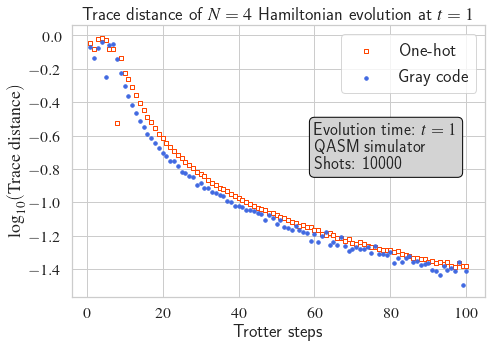

In [124]:
data_directory="../paper-data/hamiltonian-simulation"
trace_dists_oh = np.load(f'{data_directory}/one-hot-tomo-nonoise-alloptlevels.npy')
trace_dists_gc = np.load(f'{data_directory}/gray-code-tomo-nonoise-alloptlevels.npy')

colours = {"Gray code": "royalblue", "One-hot": "orangered", None: "tab:gray"}
fill_colours = {"Gray code": "cornflowerblue", "One-hot": "coral", None: "white"}
markers = {"Gray code": "o", "One-hot": "s"}

sns.set(rc={'figure.figsize':(7,5)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')

encoding="One-hot"
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), np.log10(trace_dists_oh[3,:]), 
            color=colours[encoding], 
            marker=markers[encoding], 
            facecolor=fill_colours[None],
            s=12,
            label=f"{encoding}"
           )

encoding="Gray code"
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), 
            np.log10(trace_dists_gc[3,:]),
            color=colours[encoding], 
            marker=markers[encoding], 
            facecolor=colours[encoding],
            s=12,
            label=f"{encoding}"
           )




properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
plt.text(60,-0.80,f"Evolution time: $t=1$\n QASM simulator\n Shots: 10000",fontsize=17,bbox=properties)


plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=ytick_size)
plt.xlabel("Trotter steps", fontsize=textsize)
plt.ylabel("$\log_{10}(\mathrm{Trace\,\,distance})$", fontsize=textsize)
plt.legend(fontsize=textsize)   
    
plt.title("Trace distance of $N=4$ Hamiltonian evolution at $t=1$", fontsize=textsize)
plt.tight_layout()
plt.savefig("../paper-figures/fig11-final-hamsim-qasm-tracedist.pdf")

## Fig. 12

In [147]:
data_directory="../paper-data/hamiltonian-simulation"
trace_dists_gc_measmit = np.load(f"{data_directory}/gray-code-tomo-noise-measmit-alloptlevels.npy")
trace_dists_oh_measmit = np.load(f"{data_directory}/one-hot-tomo-noise-measmit-alloptlevels.npy")

colours = {"Gray code": "royalblue", "One-hot": "orangered", None: "tab:gray"}
fill_colours = {"Gray code": "cornflowerblue", "One-hot": "coral", None: "white"}
markers = {"Gray code": "o", "One-hot": "s"}

min_trotter_steps = 1
max_trotter_steps = 100
T = 1

### Fig.12a

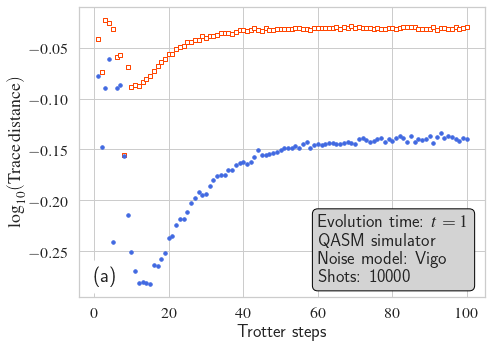

In [148]:
sns.set(rc={'figure.figsize':(7,5)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')

encoding="One-hot"
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), 
            np.log10(trace_dists_oh_measmit[2,:]), 
            color=colours[encoding], 
            marker=markers[encoding], 
            facecolor=fill_colours[None],
            s=12,
            label=f"{encoding}"
           )

encoding="Gray code"
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), 
            np.log10(trace_dists_gc_measmit[2,:]), 
            color=colours[encoding], 
            marker=markers[encoding], 
            facecolor=colours[encoding],
            s=12,
            label=f"{encoding}"
           )

properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
plt.text(60,-0.28,"Evolution time: $t=1$\n"+"QASM simulator\n Noise model: Vigo\n Shots: 10000",
         fontsize=textsize,bbox=properties
        )

properties=dict(boxstyle='round', edgecolor="white",facecolor='white', alpha=1.0)
plt.text(0,-0.28,"(a)",fontsize=20,bbox=properties)

# plt.legend(fontsize=18,loc="center",bbox_to_anchor=(0.8,0.75))   

plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=ytick_size)
plt.xlabel("Trotter steps", fontsize=textsize)
plt.ylabel("${\log_{10}(\mathrm{Trace\,distance})}$", fontsize=textsize)

    
# plt.title("Trace distance of $N=4$ Hamiltonian evolution (level 2)", fontsize=textsize)
plt.tight_layout()
plt.savefig("../paper-figures/fig12a-level2.pdf")

### Fig.12b

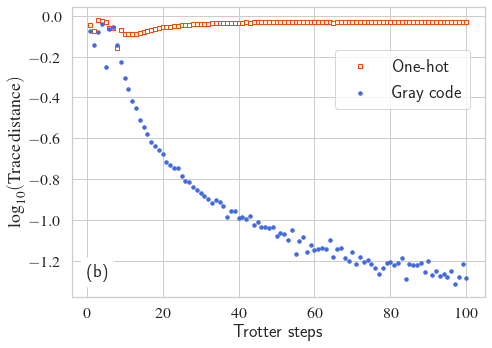

In [149]:
sns.set(rc={'figure.figsize':(7,5)})
plt.rcParams['axes.facecolor'] = 'white'
sns.set_style('whitegrid')

encoding="One-hot"            
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), 
            np.log10(trace_dists_oh_measmit[3,:]),             
            color=colours[encoding], 
            marker=markers[encoding], 
            facecolor=fill_colours[None],
            s=12,
            label=f"{encoding}"
           )

encoding="Gray code"
plt.scatter(range(min_trotter_steps, max_trotter_steps+1), 
            np.log10(trace_dists_gc_measmit[3,:]), 
            color=colours[encoding], 
            marker=markers[encoding], 
            facecolor=colours[encoding],
            s=12,
            label=f"{encoding}"
           )
            
# properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
# plt.text(65,-0.95,"Noise model: Vigo\n Time: $t=1$\n Shots: 10000",
#          fontsize=textsize,bbox=properties
#         )

properties=dict(boxstyle='round', edgecolor="white",facecolor='white', alpha=1.0)
plt.text(0,-1.28,"(b)",fontsize=textsize,bbox=properties)

plt.legend(fontsize=textsize,loc="center",bbox_to_anchor=(0.8,0.75))   

plt.xticks(fontsize=xtick_size)
plt.yticks(fontsize=ytick_size)
plt.xlabel("Trotter steps", fontsize=textsize)
plt.ylabel("$\log_{10}(\mathrm{Trace\,distance})$", fontsize=textsize)

    
# plt.title("Trace distance of $N=4$ Hamiltonian evolution (level 3)", fontsize=textsize)
plt.tight_layout()
plt.savefig("../paper-figures/fig12b-level3.pdf")

## Fig. 14

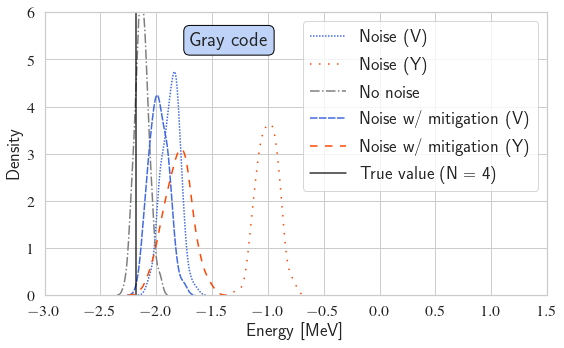

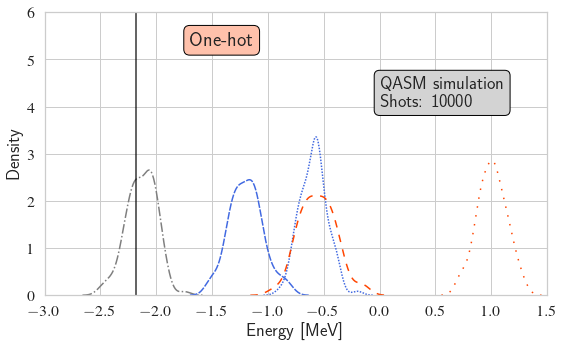

In [130]:
## Uses same data as Fig. 6 noisy_data

colours = {"vigo": "royalblue", "yorktown": "orangered", "no_device": "tab:gray"}

linestyles = {
    ("True", "vigo"): (0, (5, 1)),
    ("False", "vigo"): (0, (1, 1)),
    ("None", "no_device"): "-.",
    ("True", "yorktown"): (0, (5, 5)),
    ("False", "yorktown"): (0, (1, 5)),
}

for key, grp in noisy_data[noisy_data["n_states"] == 4].groupby("enc_type"):
    fig, ax = plt.subplots(figsize=(8, 5))

    for mit_key, mit_grp in grp.groupby(["meas_mit", "layout", "device"]):
        if mit_key[0] == "False":
            label = "Noise"
        elif mit_key[0] == "True":
            label = "Noise w/ mitigation"
        elif mit_key[0] == "None":
            label = "No noise"
        else:
            raise ValueError
        if mit_key[2] == "vigo":
            label = label + " (V)"
        elif mit_key[2] == "yorktown":
            label = label + " (Y)"

        sns.kdeplot(
            mit_grp["energy"],
            bw_method="scott",
            label=label,
            color=colours[mit_key[2]],
            linestyle=linestyles[(mit_key[0], mit_key[2])],
            ax=ax,
        )

    ax.axvline(
        x=diagonalized_values[4][1],
        color="black",
        label="True value (N = 4)",
        alpha=0.8,
    )

    if key == "Gray code":
        ax.legend(fontsize=textsize, loc="upper right")
#         properties=dict(boxstyle='round',edgecolor="black",facecolor=background_colors[key], alpha=1.0)
#         plt.text(-2.9,5.3,f"{key}",fontsize=20,bbox=properties)

    if key == "One-hot":
        properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
        plt.text(-0.0,4.0,
            "QASM simulation\nShots: 10000\nTrial: 100",
            fontsize=textsize,bbox=properties
            )
    properties=dict(boxstyle='round',edgecolor="black",facecolor=background_colors[key], alpha=1.0)
    plt.text(-1.7,5.3,f"{key}",fontsize=20,bbox=properties)

    ax.set_ylabel("Density", fontsize=textsize)
    ax.set_xlabel("Energy [MeV]", fontsize=textsize)
    ax.set_xlim(-3, 1.5)
    plt.ylim(0, 6)
    ax.tick_params(labelsize=xtick_size)

#     title_string = f"{key} encoding"
#     ax.set_title(title_string, fontsize=20)

    fig.tight_layout()
    tag="gray-code" if key =="Gray code" else "one-hot"
    plt.savefig(f"../paper-figures/fig14-{tag}.pdf")
    plt.show()

## Fig. 15

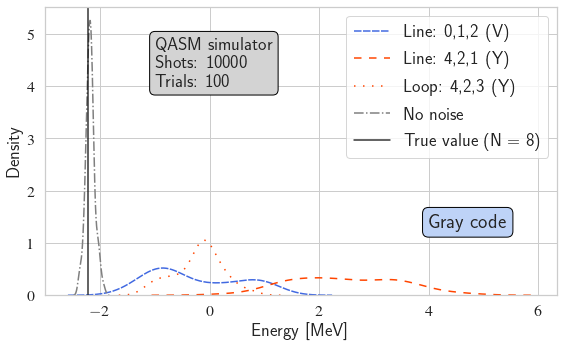

In [153]:
colours = {"vigo": "royalblue", "yorktown": "orangered", "no_device": "tab:gray"}

linestyles = {
    ("True", "vigo"): (0, (1, 1)),
    ("False", "vigo"): (0, (5, 1)),
    ("None", "no_device"): "-.",
    ("True", "yorktown"): (0, (1, 5)),
    ("False", "yorktown"): (0, (5, 5)),
}

fig, ax = plt.subplots(figsize=(8, 5))

for key, grp in noisy_data[noisy_data["n_states"] == 8].groupby(
    ["circ", "meas_mit", "enc_type", "layout", "device"]
):
    if key[2] == "Jordan-Wigner":
        continue
    if key[1] == "False":
        continue
    if key[0] == "True":
        label = f"Loop: {key[3]}"
    elif key[0] == "False":
        label = f"Line: {key[3]}"
    else:
        label = "No noise"
    if key[4] == "vigo":
        label = label + " (V)"
    elif key[4] == "yorktown":
        label = label + " (Y)"
    sns.kdeplot(
        grp["energy"],
        bw_method="scott",
        label=f"{label}",
        color=colours[key[4]],
        linestyle=linestyles[(key[0], key[4])],
        ax=ax,
    )

ax.axvline(
    x=diagonalized_values[8][1], color="black", label="True value (N = 8)", alpha=0.8
)

properties=dict(boxstyle='round', edgecolor="black",facecolor='lightgray', alpha=1.0)
plt.text(-1.0,4,"QASM simulator\nShots: 10000\nTrials: 100",
         fontsize=textsize,bbox=properties
        )

properties=dict(boxstyle='round',edgecolor="black",facecolor=background_colors["Gray code"], alpha=1.0)
plt.text(4,1.3,f"Gray code",fontsize=20,bbox=properties)

handles, labels = ax.get_legend_handles_labels()
order = [0, 1, 3, 2, 4]
handles, labels = [handles[i] for i in order], [labels[i] for i in order]
ax.legend(handles, labels, fontsize=textsize)

ax.set_ylabel("Density", fontsize=textsize)
ax.set_xlabel("Energy [MeV]", fontsize=textsize)

ax.tick_params(labelsize=xtick_size)

# title_string = f"Yorktown, meas_mit={key[1]}"
# plt.title(title_string, fontsize=20)

fig.tight_layout()

plt.savefig(f"../paper-figures/fig15-8state.pdf")
plt.show()